https://github.com/Tinkoff/invest-python/blob/main/examples/instruments.py

In [1]:
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.caching.market_data_cache.cache_settings import (
    MarketDataCacheSettings,
)
from tinkoff.invest.services import MarketDataCache
from tinkoff.invest.utils import now

from IPython.display import display
from openbb_terminal.sdk import openbb

from dataclasses import dataclass, asdict
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

with open('./tcs_token.txt', 'r') as inf:
    TOKEN = inf.read().strip()

with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2008799645', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='Финтеханализ RUB', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2023, 1, 2, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_FULL_ACCESS: 1>)])


In [2]:
import investpack
from PIL import Image

In [3]:
inst_list = """GAZP
SIBN
YNDX
TCSG
VKCO
SBER
LKOH
MTLR
ALRS
NLMK
GMKN
NVTK
SGZH
MAGN
MGNT
PIKK
DSKY
AGRO
MTSS
CHMF
ROSN
RUAL
TATN"""

2023-01-20 21:09:12.635 INFO    tinkoff.invest.logging: 63cad8c88e3991f930fd075404fdec24 FindInstrument
2023-01-20 21:09:14.580 INFO    tinkoff.invest.logging: 63c8b74ad54d9f8d4f8740716bf5fe4c GetCandles
2023-01-20 21:09:16.218 INFO    tinkoff.invest.logging: 63cad8cc176108dea8d0c64e911c2dc4 GetDividends
2023-01-20 21:09:16.932 INFO    tinkoff.invest.logging: 63cad8cc829acfe29099fc1fdc01e282 FindInstrument
2023-01-20 21:09:18.471 INFO    tinkoff.invest.logging: 63c8b71d0411c866c46c5dcb71ce688e GetCandles
2023-01-20 21:09:18.697 INFO    tinkoff.invest.logging: 63cad8ce8cd251da3132c2371b2b49c4 GetDividends
2023-01-20 21:09:19.182 INFO    tinkoff.invest.logging: 63cad8cf3e824e9955efc01c80551541 FindInstrument
2023-01-20 21:09:21.226 INFO    tinkoff.invest.logging: 63c8c22122ebfd6ebe070ee25d770a9e GetCandles
2023-01-20 21:09:22.827 INFO    tinkoff.invest.logging: 63cad8d2b25616970c3bda3e7b2c7891 GetDividends
2023-01-20 21:09:23.350 INFO    tinkoff.invest.logging: 63cad8d32b92c649d2adaa28b6

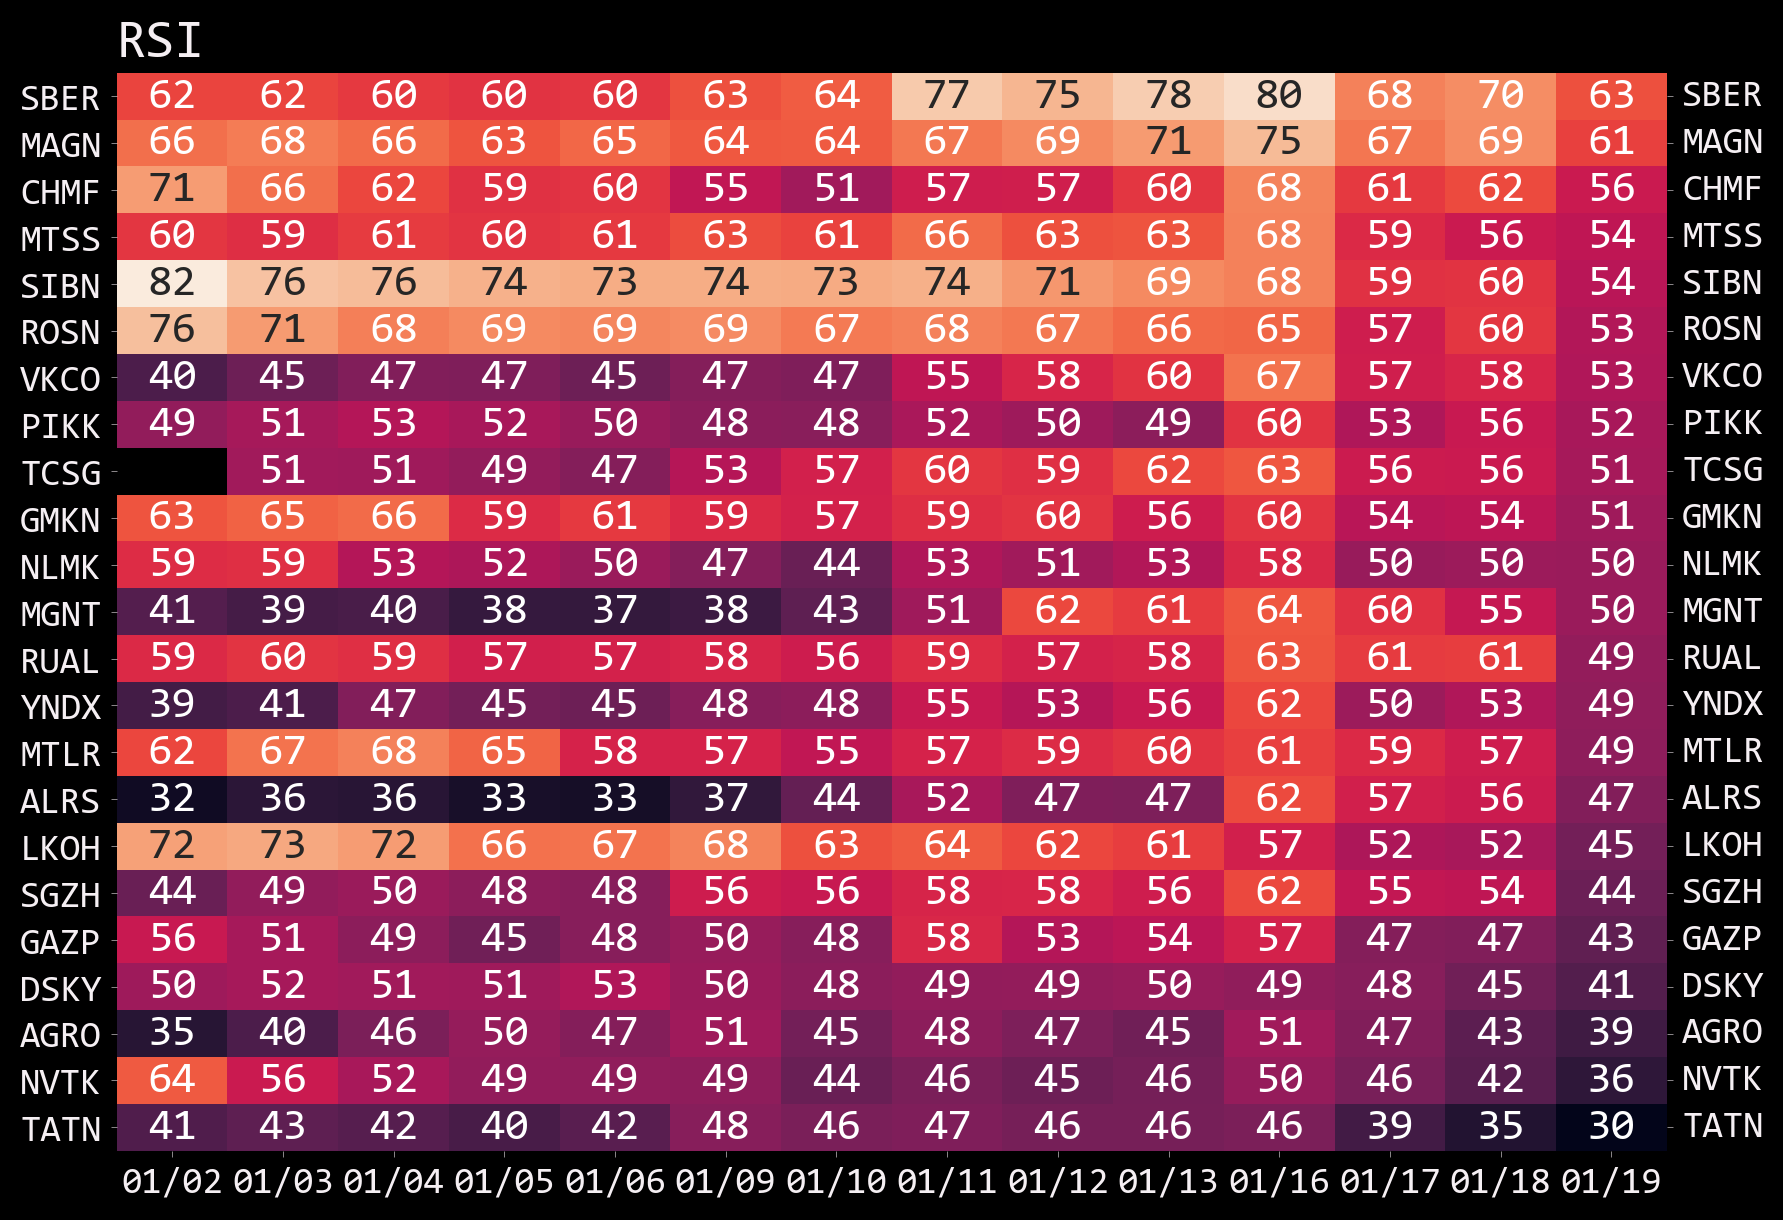

In [4]:
b = investpack.draw_rsi(inst_list, source='tcs')
Image.open(b)

100%|███████████████████████████████████████████| 23/23 [01:45<00:00,  4.58s/it]


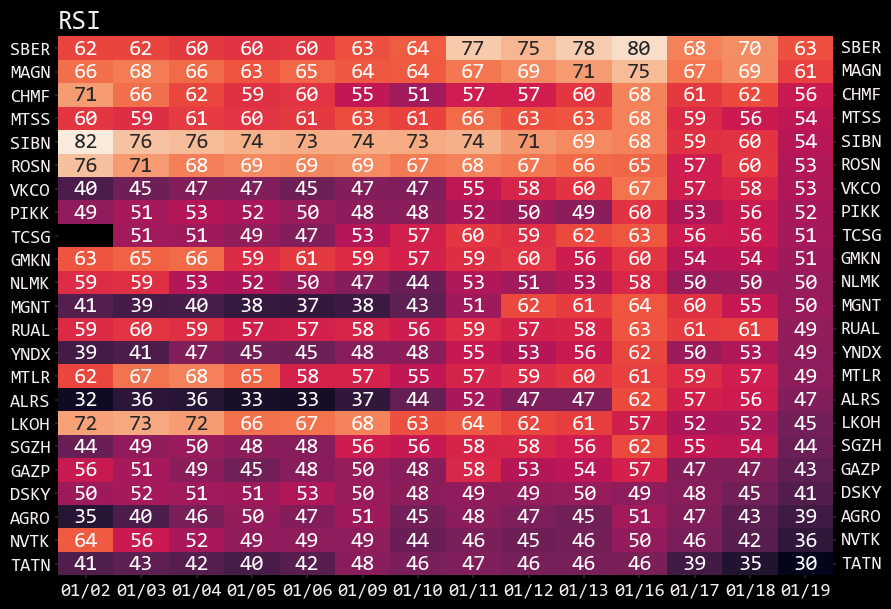

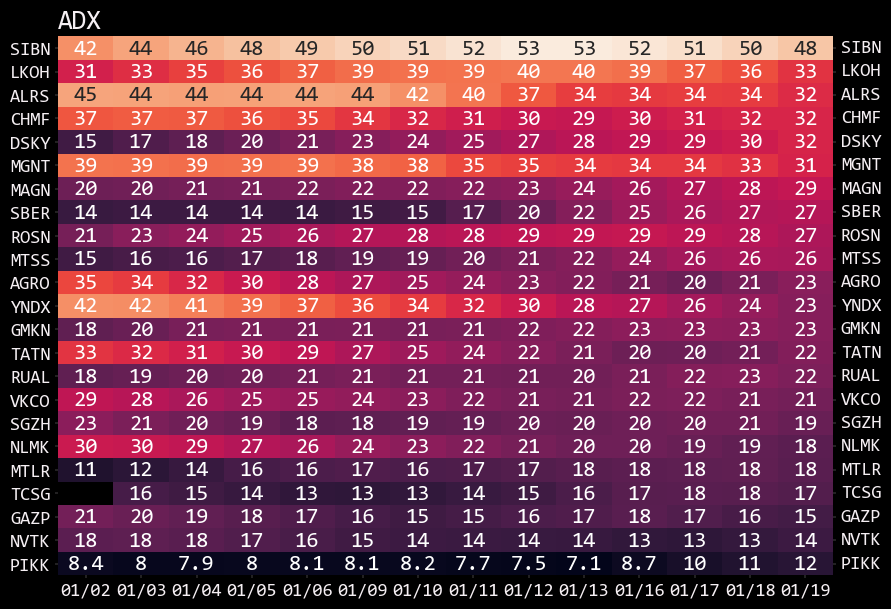

In [4]:
rsi_data = {}
adx_data = {}
for ticker in tqdm.tqdm((inst_list).split('\n')):
    data = load_tcs_data(ticker, now() - datetime.timedelta(days=365), enforce_today=True)
    rsi_data[ticker] = RSI(data)
    adx_data[ticker] = ADX(data)

rsi_data = pd.DataFrame(rsi_data)
rsi_data.index = [str(x)[-5:].replace('-', '/') for x in rsi_data.index.date]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_values(rsi_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

adx_data = pd.DataFrame(adx_data)
adx_data.index = [str(x)[-5:].replace('-', '/') for x in adx_data.index.date]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(adx_data.T.iloc[:, -14:].sort_values(adx_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('ADX')
plt.show()

In [5]:
data = load_tcs_data('SIBN', now() - datetime.timedelta(days=365), enforce_today=True)

<AxesSubplot: xlabel='date'>

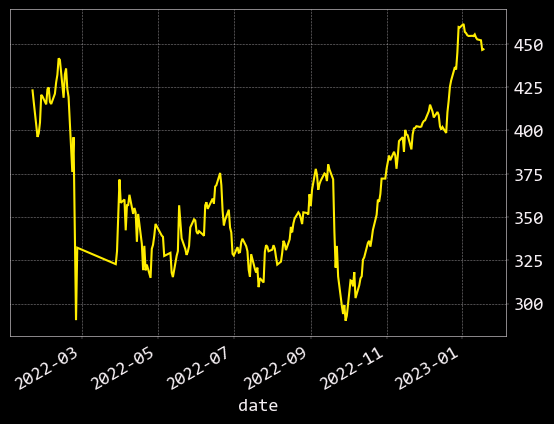

In [27]:
data['Close'].plot()

In [4]:
with Client(TOKEN) as client:
    r = client.instruments.find_instrument(query=ticker)
    figis = []
    for i in r.instruments:
        if i.instrument_type == 'share' and i.class_code == 'TQBR' and i.ticker == ticker:
            figis.append(i.figi)
    if len(figis) != 1:
        raise ValueError('Error mapping a ticker to figi')
    else:
        figi = figis[0]

    settings = MarketDataCacheSettings(base_cache_dir=Path("market_data_cache"))
    market_data_cache = MarketDataCache(settings=settings, services=client)

    candles = []
    for candle in market_data_cache.get_all_candles(
        figi=figi,
        from_=now() - datetime.timedelta(days=7),
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
    ):
        candles.append(candle)
    candle_df = candle_list_to_df(candles)

NameError: name 'ticker' is not defined

In [37]:
candle_df

,Open,High,Low,Close,Volume
date,,,,,
2023-01-11,345.4,346.5,343.0,346.0,852057
2023-01-12,345.8,347.0,344.1,345.5,504552
2023-01-13,346.4,346.4,344.7,345.4,542076


In [38]:
candle_df.groupby(level=0).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

,Open,High,Low,Close,Volume
date,,,,,
2023-01-11,345.4,346.5,343.0,346.0,852057
2023-01-12,345.8,347.0,344.1,345.5,504552
2023-01-13,346.4,346.4,344.7,345.4,542076


In [14]:
candles[-1]

HistoricCandle(open=Quotation(units=343, nano=800000000), high=Quotation(units=343, nano=800000000), low=Quotation(units=343, nano=700000000), close=Quotation(units=343, nano=800000000), volume=473, time=datetime.datetime(2023, 1, 17, 11, 54, tzinfo=datetime.timezone.utc), is_complete=True)

100%|███████████████████████████████████████████| 23/23 [00:20<00:00,  1.10it/s]


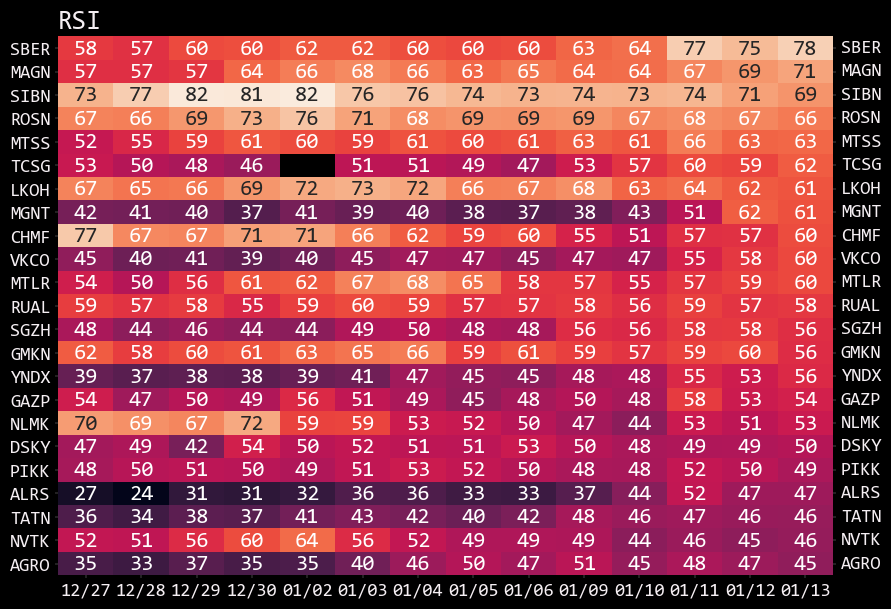

In [41]:
rsi_data = {}
for ticker in tqdm.tqdm((inst_list).split('\n')):
    data = load_tcs_data(ticker, now() - datetime.timedelta(days=365))
    rsi_data[ticker] = RSI(data)
rsi_data = pd.DataFrame(rsi_data)
rsi_data.index = [str(x)[-5:].replace('-', '/') for x in rsi_data.index.date]

plt.figure(figsize=(10, 7))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_values(rsi_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

In [86]:
def load_div_data(ticker, from_):
    with Client(TOKEN) as client:
        r = client.instruments.find_instrument(query=ticker)
        ok_instruments = []
        for i in r.instruments:
            if i.instrument_type == 'share' and i.class_code == 'TQBR' and i.ticker == ticker:
                ok_instruments.append(i)
        if len(figis) != 1:
            raise ValueError('Error mapping a ticker to figi')
        else:
            figi = ok_instruments[0].figi
            tink_inst = ok_instruments[0]

        df = pd.DataFrame([asdict(x) for x in client.instruments.get_dividends(figi=figi, from_=from_, to=now()).dividends])
        if df.empty:
            return {}
    
    df['yield_value'] = df['yield_value'].apply(q2n)
    df['last_buy_date'] = df['last_buy_date'].dt.tz_localize(None).dt.floor('1D')
    df = df[(pd.to_datetime(df.payment_date).dt.tz_localize(None) > pd.to_datetime(0)) &
                           (df.dividend_type != 'Cancelled')]
    df = df[['yield_value', 'last_buy_date']].groupby('last_buy_date')['yield_value'].sum()
    return df.to_dict()

In [89]:
for ticker in sorted((inst_list).split('\n')):
    print(ticker, load_div_data(ticker, now() - datetime.timedelta(days=365)))

AGRO {}
ALRS {}
CHMF {}
DSKY {}
GAZP {Timestamp('2022-10-07 00:00:00'): 25.34}
GMKN {Timestamp('2022-01-12 00:00:00'): 6.33, Timestamp('2022-06-10 00:00:00'): 5.98}
LKOH {Timestamp('2022-12-19 00:00:00'): 17.22}
MAGN {Timestamp('2022-01-11 00:00:00'): 3.81}
MGNT {}
MTLR {}
MTSS {Timestamp('2022-07-08 00:00:00'): 12.31}
NLMK {}
NVTK {Timestamp('2022-04-29 00:00:00'): 4.07, Timestamp('2022-10-05 00:00:00'): 4.49}
PIKK {}
ROSN {Timestamp('2022-07-06 00:00:00'): 6.39, Timestamp('2023-01-10 00:00:00'): 5.57}
SBER {}
SGZH {Timestamp('2022-05-31 00:00:00'): 7.11}
SIBN {Timestamp('2022-07-06 00:00:00'): 4.03}
TCSG {}
VKCO {}
YNDX {}


In [79]:
print([x for x in sorted(inst_list.split('\n')) if x not in list(all_divs.ticker)])

['AGRO', 'ALRS', 'CHMF', 'DSKY', 'MGNT', 'MTLR', 'NLMK', 'PIKK', 'SBER', 'TCSG', 'VKCO', 'YNDX']


In [78]:
all_divs.sort_values('ticker')

,dividend_net,payment_date,declared_date,last_buy_date,dividend_type,record_date,regularity,close_price,yield_value,created_at,ticker
0,"{'currency': 'rub', 'units': 51, 'nano': 30000...",2022-11-15 00:00:00+00:00,2022-09-30 00:00:00+00:00,2022-10-07,,2022-10-11 00:00:00+00:00,,"{'currency': 'rub', 'units': 201, 'nano': 4000...",25.34,2022-11-11 02:07:37.654754+00:00,GAZP
0,"{'currency': 'rub', 'units': 1166, 'nano': 220...",2022-07-19 00:00:00+00:00,2022-06-03 00:00:00+00:00,2022-06-10,,2022-06-14 00:00:00+00:00,,"{'currency': 'rub', 'units': 19490, 'nano': 0}",5.98,2022-07-18 02:01:35.519343+00:00,GMKN
1,"{'currency': 'rub', 'units': 1523, 'nano': 170...",2022-02-18 00:00:00+00:00,2021-12-27 00:00:00+00:00,2022-01-12,,2022-01-14 00:00:00+00:00,,"{'currency': 'rub', 'units': 24050, 'nano': 0}",6.33,2022-06-10 13:07:12.241344+00:00,GMKN
0,"{'currency': 'rub', 'units': 256, 'nano': 0}",2023-01-31 00:00:00+00:00,2022-12-05 00:00:00+00:00,2022-12-19,,2022-12-21 00:00:00+00:00,,"{'currency': 'rub', 'units': 4606, 'nano': 500...",5.56,2023-01-12 02:00:18.699573+00:00,LKOH
1,"{'currency': 'rub', 'units': 537, 'nano': 0}",2023-01-31 00:00:00+00:00,2022-12-05 00:00:00+00:00,2022-12-19,,2022-12-21 00:00:00+00:00,,"{'currency': 'rub', 'units': 4606, 'nano': 500...",11.66,2023-01-12 02:00:18.699573+00:00,LKOH
0,"{'currency': 'rub', 'units': 2, 'nano': 663000...",2022-01-27 00:00:00+00:00,2021-10-25 00:00:00+00:00,2022-01-11,Interim,2022-01-13 00:00:00+00:00,Quarter,"{'currency': 'rub', 'units': 69, 'nano': 84500...",3.81,2022-05-27 06:05:30.479369+00:00,MAGN
0,"{'currency': 'rub', 'units': 33, 'nano': 85000...",2022-08-16 00:00:00+00:00,2022-06-22 00:00:00+00:00,2022-07-08,,2022-07-12 00:00:00+00:00,,"{'currency': 'rub', 'units': 275, 'nano': 5000...",12.31,2022-08-12 02:07:06.838019+00:00,MTSS
0,"{'currency': 'rub', 'units': 45, 'nano': 0}",2022-11-14 00:00:00+00:00,2022-09-28 00:00:00+00:00,2022-10-05,,2022-10-09 00:00:00+00:00,,"{'currency': 'rub', 'units': 1002, 'nano': 800...",4.49,2022-11-09 02:07:03.932985+00:00,NVTK
1,"{'currency': 'rub', 'units': 43, 'nano': 77000...",2022-05-23 00:00:00+00:00,2022-03-18 00:00:00+00:00,2022-04-29,Final,2022-05-05 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 1076, 'nano': 0}",4.07,2022-06-05 02:48:52.737965+00:00,NVTK
0,"{'currency': 'rub', 'units': 20, 'nano': 39000...",2023-02-16 00:00:00+00:00,2022-12-23 00:00:00+00:00,2023-01-10,,2023-01-12 00:00:00+00:00,,"{'currency': 'rub', 'units': 366, 'nano': 0}",5.57,2023-01-12 02:07:14.781910+00:00,ROSN


In [5]:
import tinkoff.invest.services as sss
all_divs = []
with Client(TOKEN) as client:
    for ticker in tqdm.tqdm((inst_list).split('\n')):
        r = client.instruments.find_instrument(query=ticker)
        ok_instruments = []
        for i in r.instruments:
            if i.instrument_type == 'share' and i.class_code == 'TQBR' and i.ticker == ticker:
                ok_instruments.append(i)
        if len(ok_instruments) != 1:
            raise ValueError('Error mapping a ticker to figi')
        else:
            figi = ok_instruments[0].figi
            tink_inst = ok_instruments[0]

        settings = MarketDataCacheSettings(base_cache_dir=Path("market_data_cache"))
        market_data_cache = MarketDataCache(settings=settings, services=client)

    #     div_req = sss.GetDividendsRequest(figi, now() - datetime.timedelta(days=365))
#         print((client.instruments.get_dividends(figi=figi, from_=now() - datetime.timedelta(days=365), to=now()).dividends))
        df = pd.DataFrame([asdict(x) for x in client.instruments.get_dividends(figi=figi, from_=now() - datetime.timedelta(days=365), to=now()).dividends])
        df['ticker'] = ticker
        all_divs.append(df)
all_divs = pd.concat(all_divs)
# all_divs['yield_value'] = all_divs['yield_value'].apply(q2n)
# all_divs['last_buy_date'] = all_divs['last_buy_date'].dt.tz_localize(None).dt.floor('1D')
# all_divs = all_divs[(pd.to_datetime(all_divs.payment_date).dt.tz_localize(None) > pd.to_datetime(0)) &
#                     (all_divs.dividend_type != 'Cancelled')]
# all_divs = all_divs[['ticker', 'yield_value', 'last_buy_date']].groupby(['ticker', 'last_buy_date'], as_index=False)['yield_value'].sum()

100%|███████████████████████████████████████████| 21/21 [00:08<00:00,  2.48it/s]


In [7]:
all_divs[all_divs.ticker == 'SIBN']

,dividend_net,payment_date,declared_date,last_buy_date,dividend_type,record_date,regularity,close_price,yield_value,created_at,ticker
0,"{'currency': 'rub', 'units': 69, 'nano': 78000...",2023-02-09 00:00:00+00:00,2022-12-19 00:00:00+00:00,2022-12-28 00:00:00+00:00,,2022-12-30 00:00:00+00:00,,"{'currency': 'rub', 'units': 514, 'nano': 8000...","{'units': 13, 'nano': 550000000}",2023-01-13 02:47:06.454776+00:00,SIBN
1,"{'currency': 'rub', 'units': 16, 'nano': 0}",2022-08-12 00:00:00+00:00,2022-06-24 00:00:00+00:00,2022-07-06 00:00:00+00:00,,2022-07-08 00:00:00+00:00,,"{'currency': 'rub', 'units': 397, 'nano': 3500...","{'units': 4, 'nano': 30000000}",2022-09-28 02:06:09.624688+00:00,SIBN


In [20]:
ticker = 'SIBN'
data = load_tcs_data(ticker, now() - datetime.timedelta(days=5*365))

Text(0.0, 1.0, 'SIBN | 2023-01-10: Price=454.50, MA50=465.10, MA200=416.73')

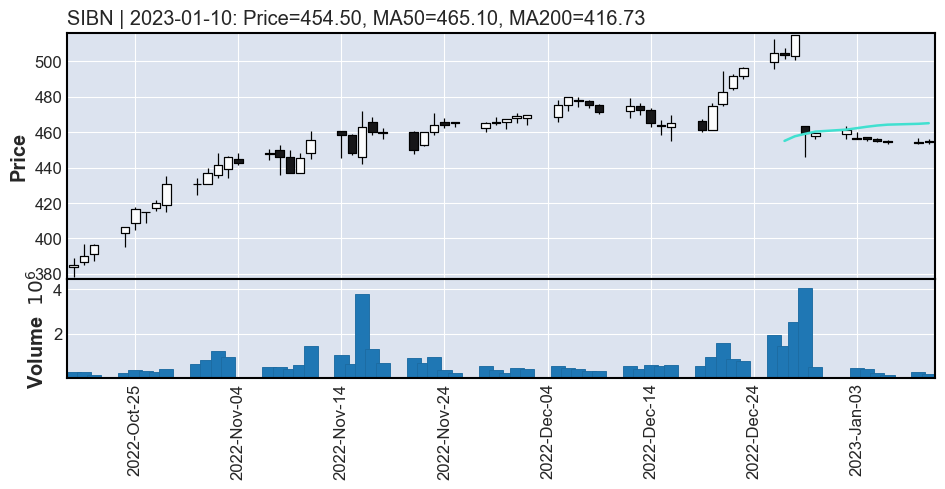

In [21]:
fig, axlist = mpf.plot(
    data[-60:],
    type='candle',
    mav=(50, 200),
    volume=True,
    show_nontrading=True,
    figsize=(10, 4), xrotation=90, tight_layout=True, returnfig=True)
# axlist[-2].xaxis.set_ticks(data.index[::len(data)//20])
# axlist[-2].set_xticklabels(data.index[::len(data)//20].strftime('%Y.%m.%d'))
axlist[0].set_title(
    ticker + ' | ' + f'{data.index[-1].date()}: Price={data["Close"][-1]:.2f}, MA50={data["Close"].rolling(window=50).mean()[-1]:.2f}'
    f', MA200={data["Close"].rolling(window=200).mean()[-1]:.2f}',
    loc='left')